# Mathematical Foundations of Computer Graphics and Vision 2022
## Exercise 4 - OPTIMAL TRANSPORT AND GRAPH CUTS
## PART 1: Optimal Transport
### 1.1. Task 1 - Optimal Transport in 1D

In [1]:
! pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

Sample n = 10000 points from each distribution and plot them

<AxesSubplot:ylabel='Count'>

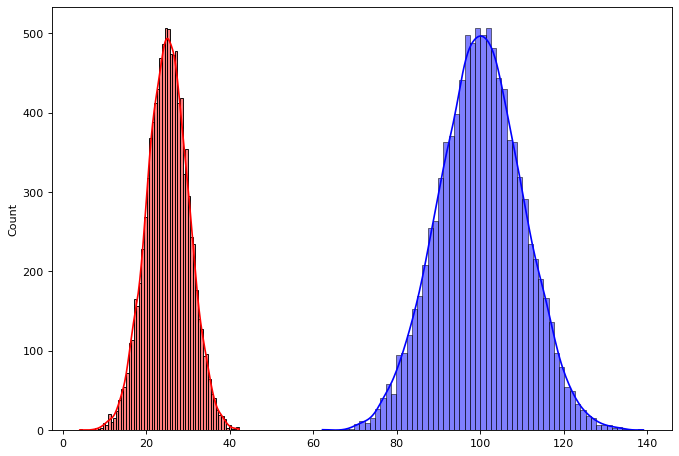

In [2]:
n = 10000
mu_x = 25
sigma_x = 5
mu_y = 100
sigma_y = 10

plt.figure(figsize=(10,7), dpi= 80)
x_dist = np.random.normal(mu_x,sigma_x,n)
y_dist = np.random.normal(mu_y,sigma_y,n)
sns.histplot(x_dist, color="red", kde=True)
sns.histplot(y_dist, color="blue", kde=True)

Compute the optimal transport between the two sets of samples, using the algorithm described above.

In [3]:
x_dist = np.sort(x_dist)
y_dist = np.sort(y_dist)
W_opt = 0
P_i_j = 1
for x, y in zip(x_dist, y_dist):
    W_opt += ((x - y)**2 ) * P_i_j/ n
print("Optimal transport: %f"%(W_opt))

Optimal transport: 5659.170390


There is a closed form solution for Optimal Transport between Gaussians in $\mathbb R^d$:
$$W^2_2(μ_1,μ_2)=∥m_1 −m_2∥^2_2+trace(Σ_1 +Σ_2 −2(Σ^{1/2}_2Σ_1Σ^{1/2}_2)^{1/2})$$
with $μ_1 = N (m_1, Σ_1)$ and $μ_2 = N (m_2, Σ_2)$. Use this equation to verify your OT result.

In [4]:
W_opt_close = (mu_x - mu_y)**2 + (sigma_x + sigma_y - 2*np.sqrt(sigma_x*sigma_y))
print("Optimal transport verify: %f"%(W_opt_close))

Optimal transport verify: 5625.857864


Generate samples by interpolating between the two distribution using the obtained matching: $z_λ =λx+(1−λ)y$. Using Gaussian kernels, estimate the probability density function (PDF) of the resulting samples. For $λ ∈ \{0.25, 0.5, 0.75\}$, plot the results.

* **Note that here I use sns to plot the density function, according to the [documentation](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) uses Gaussian kernels**

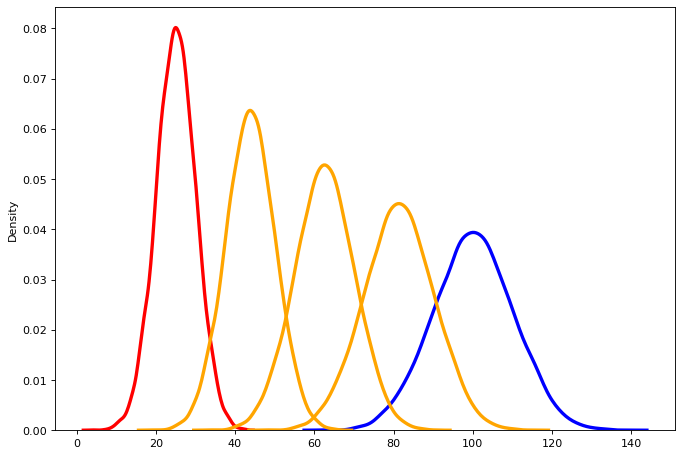

In [5]:
plt.figure(figsize=(10,7), dpi= 80)
sns.kdeplot(x_dist, color="red", linewidth=3)
sns.kdeplot(y_dist, color="blue", linewidth=3)
for lmbda in [0.25,0.5,0.75]:
    z_dist = lmbda * x_dist + (1 - lmbda) * y_dist
    sns.kdeplot(z_dist, color="orange", linewidth=3)

### 1.2. Task 2 - Color Transfer Using Sliced Optimal Transport

In [6]:
!pip install opencv-python
!pip install tqdm
import cv2
from tqdm import tqdm

Read the images and transform them into numpy arrays of shape (width, height, channels) with values in range `[0, 1]`. We recommend working at 14 of the original resolution (especially during tests).

In [7]:
src_img = plt.imread('./src.png')
tar_img = plt.imread('./dst.png')
src_img = cv2.resize(src_img, ( int(src_img.shape[1]/4), int(src_img.shape[0]/4) ))
tar_img = cv2.resize(tar_img, ( int(tar_img.shape[1]/4), int(tar_img.shape[0]/4) ))

Write a function that creates a random normalized vector $\vec{\theta}$ in 3D

In [8]:
def generate_direction(num):
    theta = np.random.uniform(-1,1,(num, 3))
    return theta / np.sqrt((theta**2).sum(axis = 1))[:,None]

Create two sets of RGB values from the source and target images. Project the two pixel sets on the direction defined by $\vec{\theta}$, to respectively obtain the sets $\{x_i\}$ and $\{y_j\}$. Using OT in 1D, find the optimal transport plan between the two projected sets. We use the optimal transport plan to get the update to make on the source as $u_i  \vec{\theta}$, with $u_i = y_{si} − x_i$ and $s_i$ indicating the index of the matching value from $\{y_i\}$. To make this update step more robust, select multiple random directions and average the obtained update steps. To compute the color transfer, this operation needs to be repeated several times.

In [9]:
direction_num = 5
max_iter = 100
out_img = src_img
for i in tqdm(range(max_iter)):
    theta = generate_direction(direction_num)
    x_dist, y_dist = out_img.reshape(-1, 3) @ theta.T, tar_img.reshape(-1, 3) @ theta.T
    x_order, y_order = np.argsort(x_dist, axis = 0), np.argsort(y_dist, axis = 0)
    x_order_inverse = np.argsort(x_order, axis = 0)
    u = np.take_along_axis(y_dist, y_order, axis=0) - np.take_along_axis(x_dist, x_order, axis=0)
    u = np.take_along_axis(u, x_order_inverse, axis = 0)
    u /= u.shape[1]
    delta = u@theta
    out_img = (out_img.reshape(-1, 3) + delta).reshape(out_img.shape[0], out_img.shape[1], -1)
out_img = (out_img - out_img.min()) / (out_img.max() - out_img.min())

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


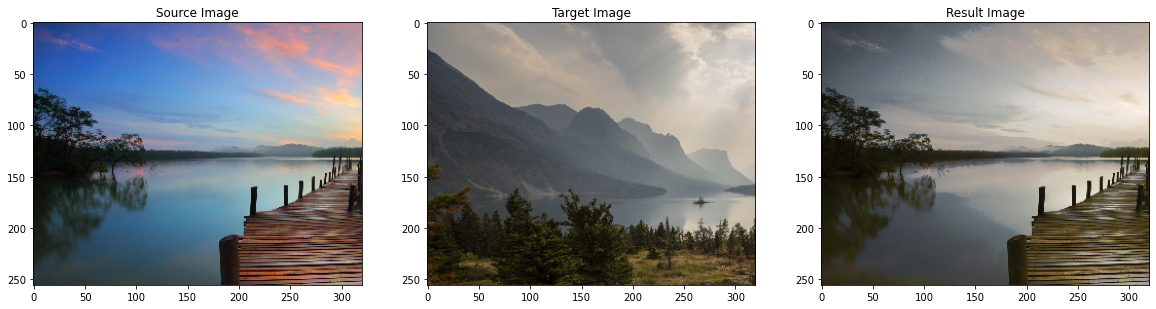

In [10]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax1.title.set_text('Source Image')
ax2.title.set_text('Target Image')
ax3.title.set_text('Result Image')
ax1.imshow(src_img) 
ax2.imshow(tar_img) 
ax3.imshow(out_img) 